# ORFit Demo


# 0. Imports and Helper Functions

In [1]:
try:
    import dynamax
    import flax
    import augly
    import torchvision
    from tqdm import tqdm
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    print('installing flax')
    %pip install flax
    print('installing augly')
    %pip install augly
    print('installing torchvision')
    %pip install torchvision
    print('installing tqdm')
    %pip install tqdm
    import dynamax
    import flax
    import augly
    import torchvision
    from tqdm import tqdm

/Users/peterchang/Desktop/Repos/transformers_private-2/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Sequence
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax import jacrev
from jax import vmap
from jax.lax import scan
from jax.lax import cond
from jax.flatten_util import ravel_pytree
import flax.linen as nn

from dynamax.rebayes.utils import MLP, get_mlp_flattened_params
from dynamax.utils import datasets
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
from dynamax.generalized_gaussian_ssm.inference import EKFIntegrals, conditional_moments_gaussian_filter
from dynamax.rebayes.orfit import orthogonal_recursive_fitting, ORFitParams

In [3]:
def plot_rmse(params_history, apply_fn, X, y, ax=None, title=''):
    if ax == None:
        fig, ax = plt.subplots()
    if title == None:
        title = 'RMSE'
    def compute_rmse(params, X, y):
        y_pred = vmap(apply_fn, (None, 0))(params, X)
        return jnp.sqrt(jnp.mean((y_pred - y)**2))
    rmses = vmap(compute_rmse, (0, None, None))(params_history, X, y)
    ax.plot(jnp.arange(len(rmses)), rmses)
    ax.set_title(title);
    return ax

# 1. Underparameterized Linear Regression

In [4]:
def generate_linreg_dataset(num_points=200, theta=jnp.array([2.5, 0.5]), var=0.01, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = theta[1]*X + theta[0]
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]

    return X, X_sh, Y, Y_sh, Y_tr

In [5]:
X_lr, X_lr_sh, Y_lr, Y_lr_sh, Y_lr_tr = generate_linreg_dataset(20)

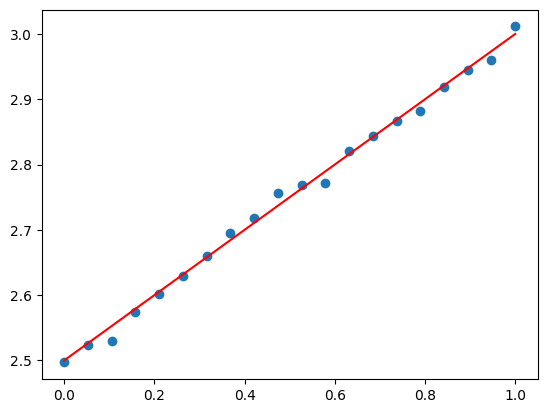

In [6]:
plt.scatter(X_lr, Y_lr)
plt.plot(X_lr, Y_lr_tr, c='red');

In [7]:
# Define Linear Regression as single layer perceptron
input_dim_lr, hidden_dims_lr, output_dim_lr = 1, [], 1
model_dims_lr = [input_dim_lr, *hidden_dims_lr, output_dim_lr]
_, flat_params_lr, _, apply_fn_lr = get_mlp_flattened_params(model_dims_lr)
print(flat_params_lr.shape)

(2,)


In [8]:
# L2 loss
loss_fn_lr = lambda w, x, y: (apply_fn_lr(w, x) - y)**2

# Define ORFit parameters
model_params_lr = ORFitParams(
    initial_mean=flat_params_lr,
    initial_variance=1.0,
    apply_function=apply_fn_lr,
    loss_function=loss_fn_lr,
    memory_size=20,
)

# Run full-memory ORFit
posterior_lr = orthogonal_recursive_fitting(model_params_lr, Y_lr_sh, X_lr_sh)

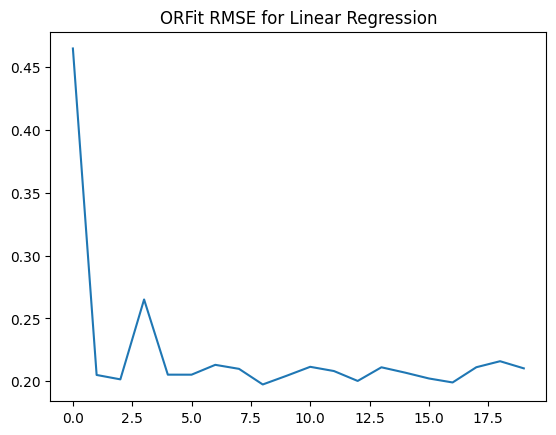

In [9]:
fig, ax = plt.subplots()
plot_rmse(posterior_lr.filtered_means, apply_fn_lr, X_lr, Y_lr, ax, 'ORFit RMSE for Linear Regression');

# 2. Nonlinear Regression

In [10]:
def generate_nonlinreg_dataset(num_points=200, fn=lambda x: jnp.sin(5*x**2 - 1), var=0.001, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = vmap(fn)(X)
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]
    return X, X_sh, Y, Y_sh, Y_tr

In [11]:
X_nr, X_nr_sh, Y_nr, Y_nr_sh, Y_nr_tr = generate_nonlinreg_dataset()

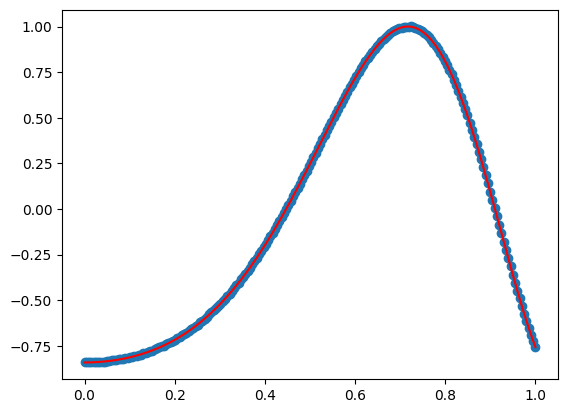

In [12]:
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, Y_nr_tr, c='red');

In [13]:
# Define Non-Linear Regression as MLP with two hidden layers
input_dim_nr, hidden_dims_nr, output_dim_nr = 1, [30, 30,], 1
model_dims_nr = [input_dim_nr, *hidden_dims_nr, output_dim_nr]
_, flat_params_nr, _, apply_fn_nr = get_mlp_flattened_params(model_dims_nr)
print(flat_params_nr.shape)

(1021,)


In [29]:
# L2 loss
loss_fn_nr = lambda w, x, y: (apply_fn_nr(w, x) - y)**2

# Define ORFit parameters
model_params_nr = ORFitParams(
    initial_mean=flat_params_nr,
    initial_variance=1.0,
    apply_function=apply_fn_nr,
    loss_function=loss_fn_nr,
    memory_size=30,
)

# Run full-memory ORFit
posterior_nr = orthogonal_recursive_fitting(model_params_nr, Y_nr_sh, X_nr_sh)
filtered_means = posterior_nr.filtered_means

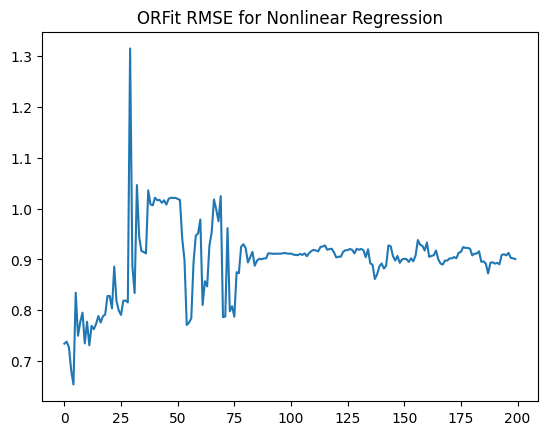

In [30]:
fig, ax = plt.subplots()
plot_rmse(filtered_means, apply_fn_nr, X_nr_sh, Y_nr_sh, ax, 'ORFit RMSE for Nonlinear Regression');

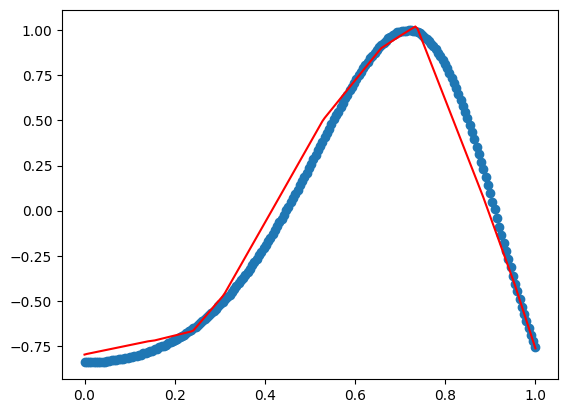

In [31]:
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, vmap(apply_fn_nr, (None, 0))(filtered_means[-1], X_nr), c='red');

# 3. Rotating MNIST

## 3.1 Load Dataset

In [37]:
# Load rotated MNIST dataset
np.random.seed(314)
num_train = 100

train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_train = jnp.array(X_train)[:num_train]
y_train = jnp.array(y_train)[:num_train]

ix_sort = jnp.argsort(y_train)
X_train_inc = X_train[ix_sort]
y_train_inc = y_train[ix_sort]

In [38]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

X_train_inc = (X_train_inc - X_train_inc.mean()) / X_train_inc.std()

In [39]:
# Define Linear Regression as single layer perceptron
input_dim_rmnist, hidden_dims_rmnist, output_dim_rmnist = 784, [], 1
model_dims_rmnist = [input_dim_rmnist, *hidden_dims_rmnist, output_dim_rmnist]
_, flat_params_rmnist, _, apply_fn_rmnist = get_mlp_flattened_params(model_dims_rmnist)
print(flat_params_rmnist.shape)

# L2 loss
loss_fn_rmnist = lambda w, x, y: (apply_fn_rmnist(w, x) - y)**2

(785,)


In [40]:
# L2 loss
loss_fn_rmnist = lambda w, x, y: (apply_fn_rmnist(w, x) - y)**2

# Define ORFit parameters
model_params_rmnist = ORFitParams(
    initial_mean=flat_params_rmnist,
    initial_variance=1.0,
    apply_function=apply_fn_rmnist,
    loss_function=loss_fn_rmnist,
    memory_size=30,
)

# Run full-memory ORFit
posterior_nr = orthogonal_recursive_fitting(model_params_nr, Y_nr_sh, X_nr_sh)
filtered_means = posterior_nr.filtered_means

100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


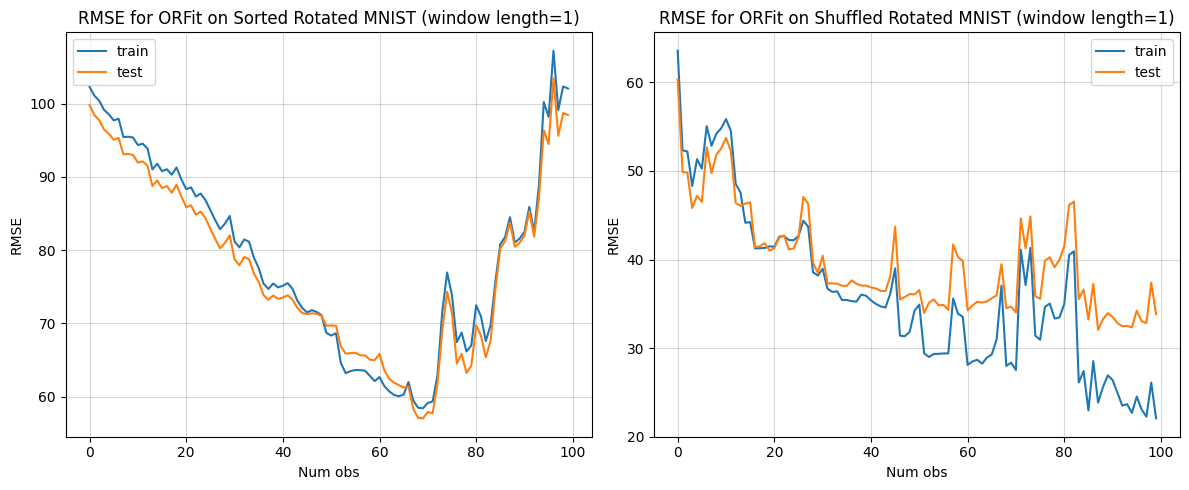

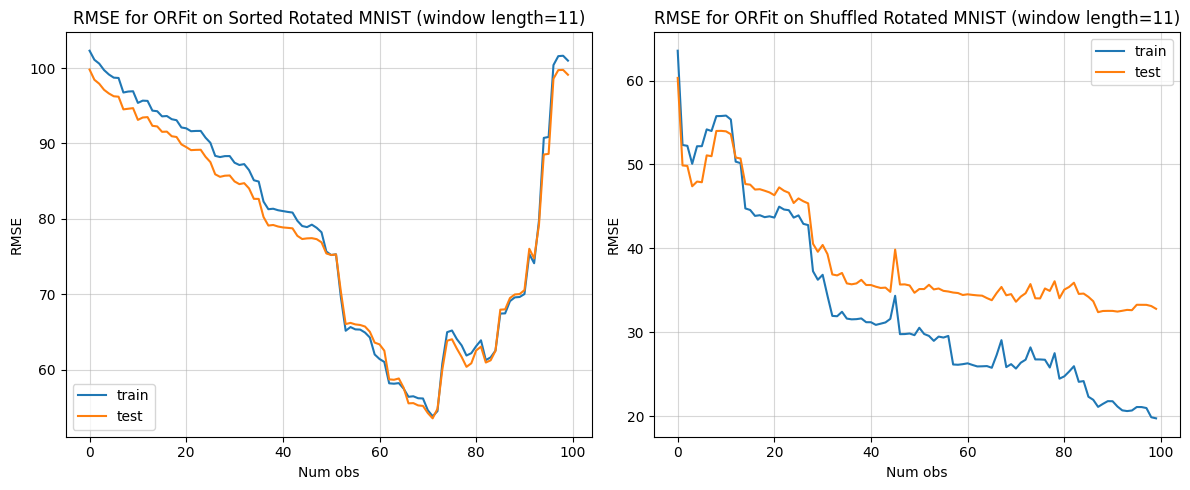

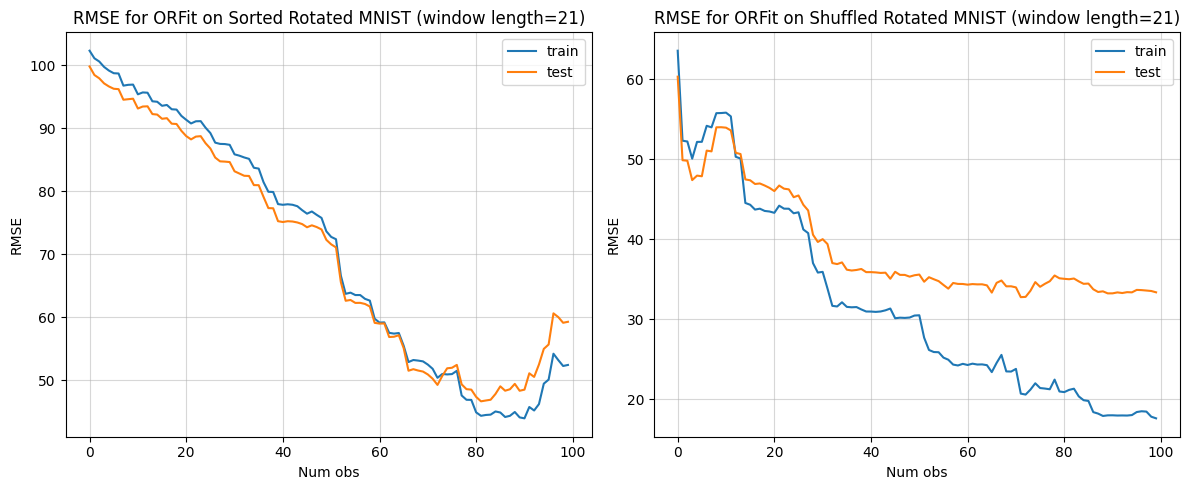

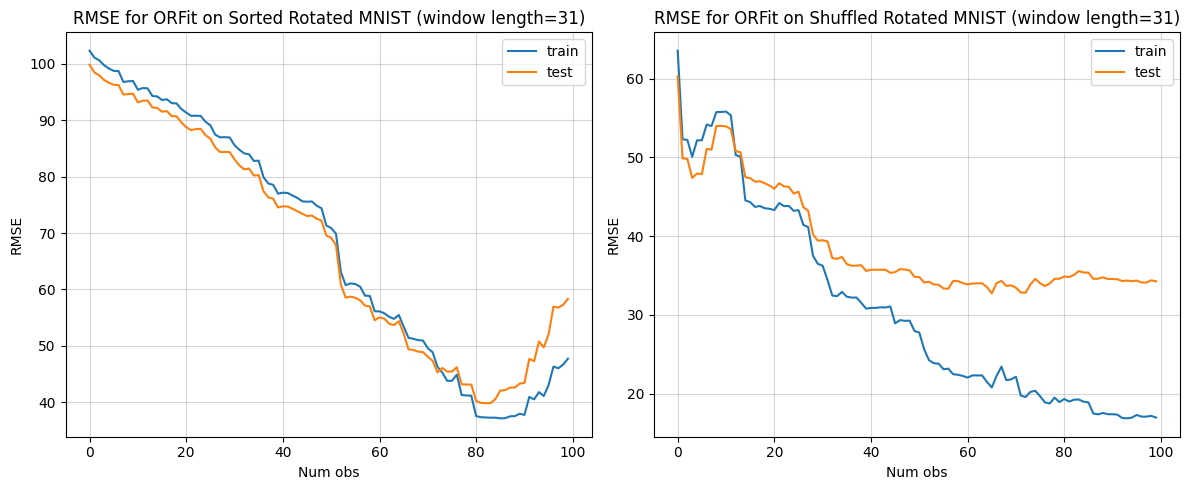

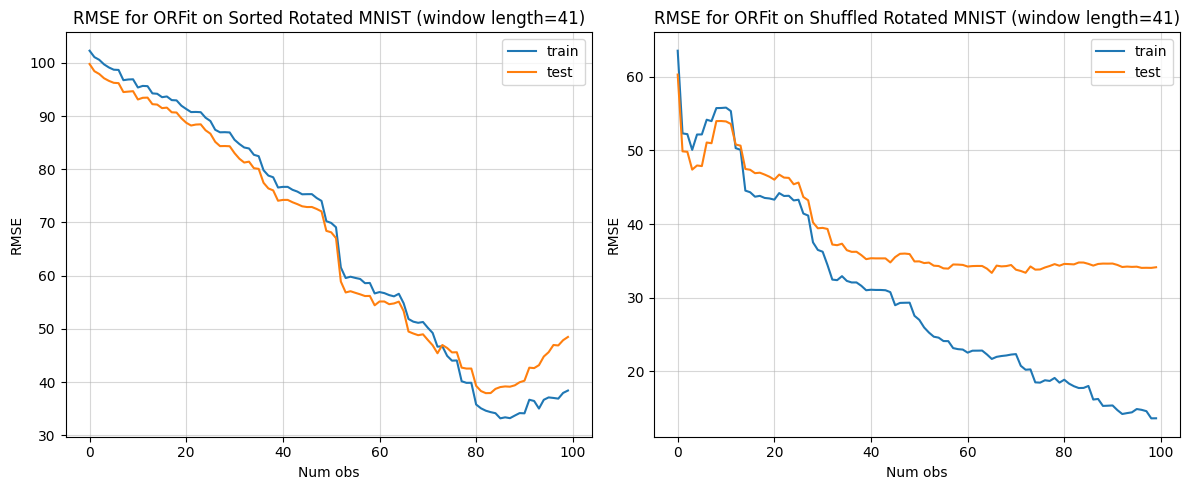

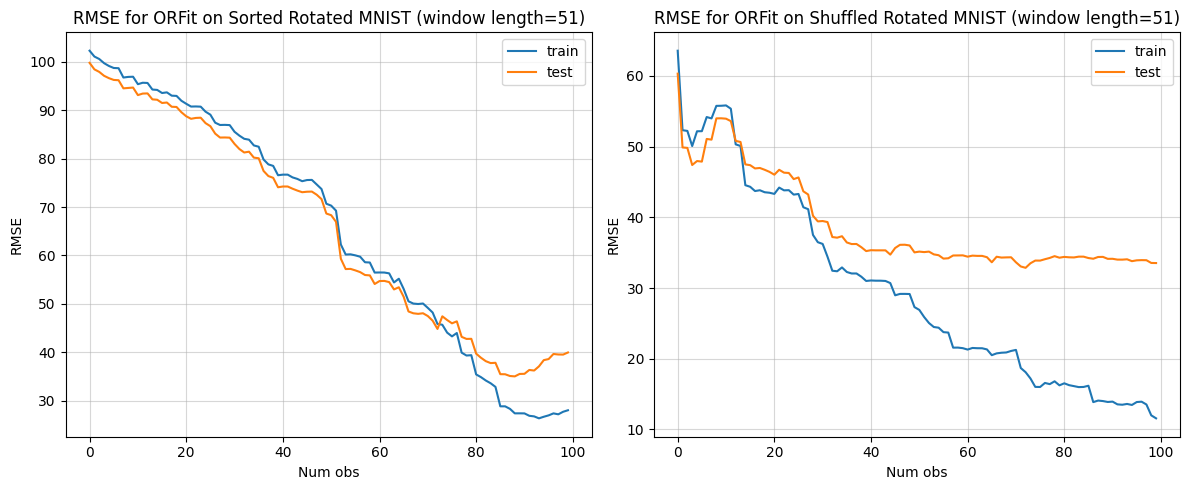

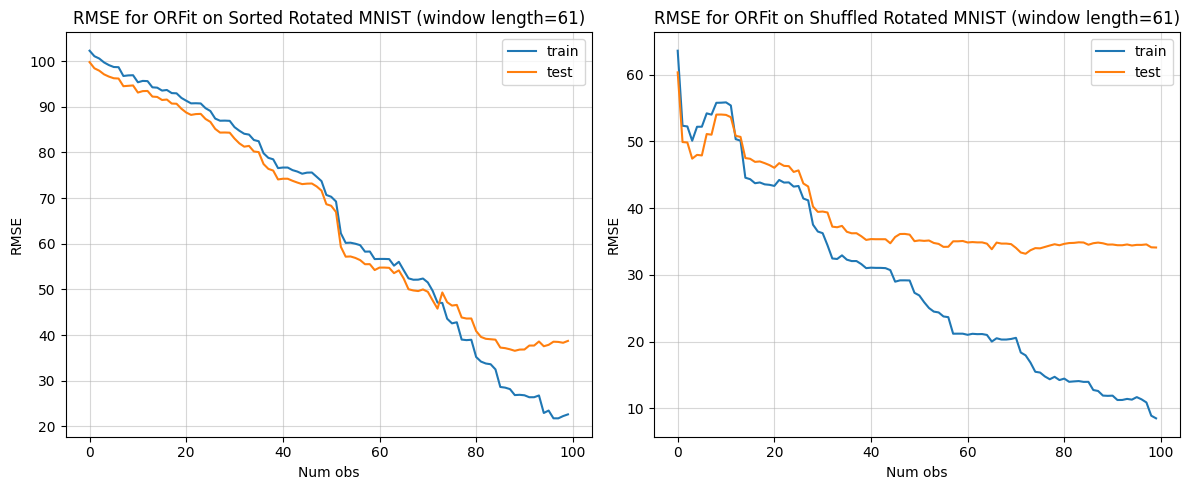

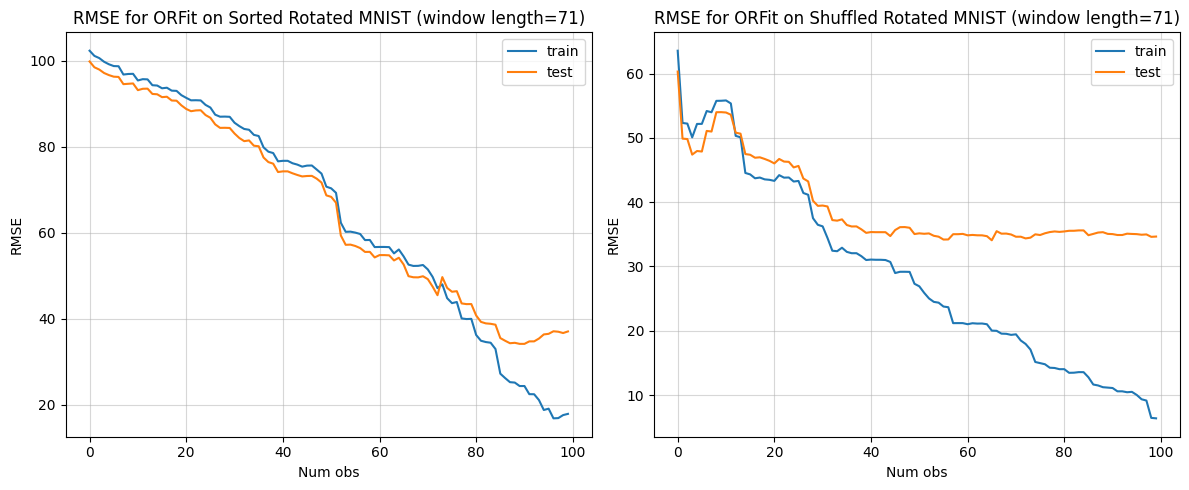

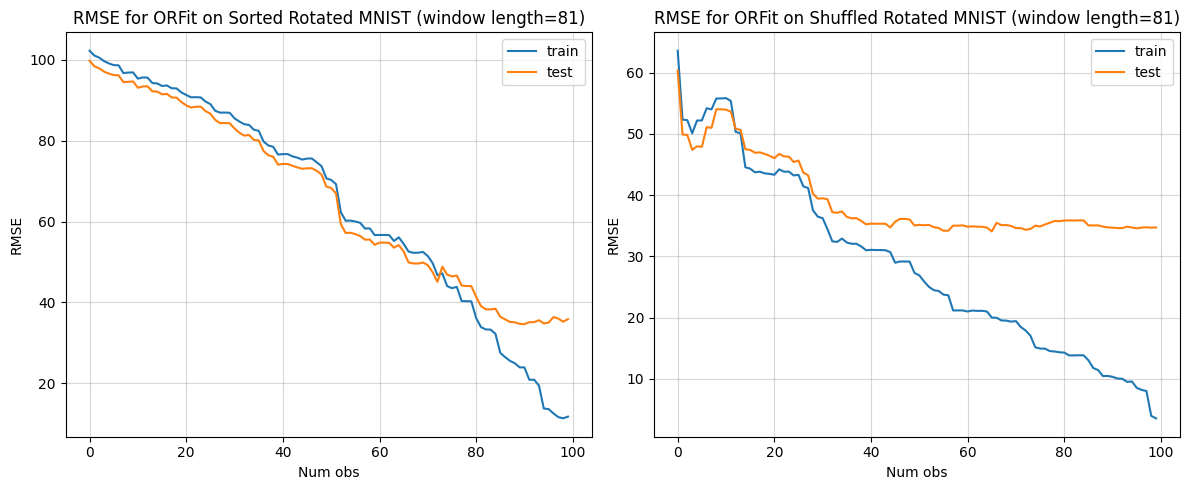

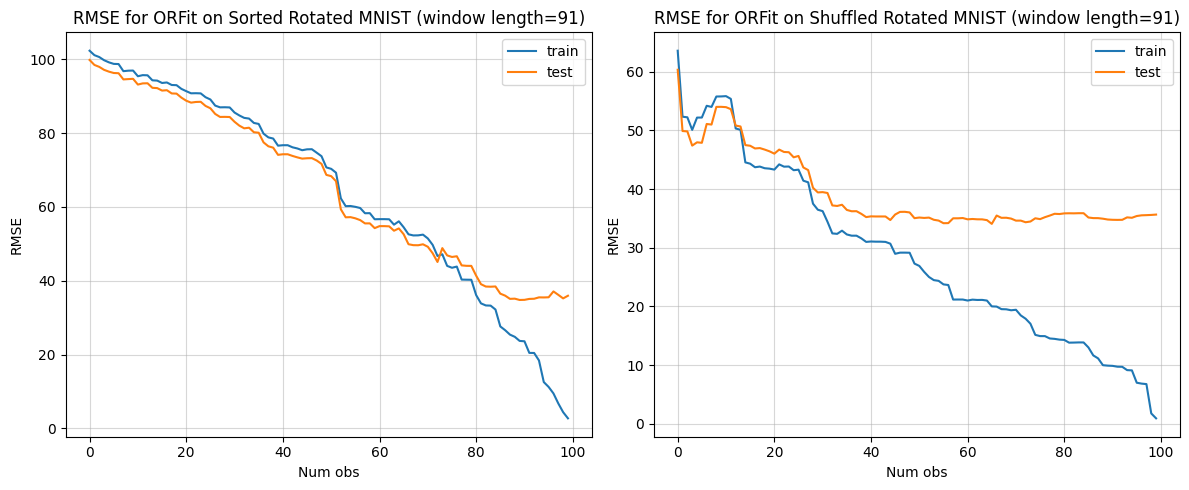

In [41]:
for win_len in tqdm(range(1, 101, 10)):
    # Define ORFit parameters
    model_params_rmnist = ORFitParams(
        initial_mean=flat_params_rmnist,
        initial_variance=1.0,
        apply_function=apply_fn_rmnist,
        loss_function=loss_fn_rmnist,
        memory_size=win_len,
    )

    # Run ORFit
    posterior_rmnist_inc = orthogonal_recursive_fitting(model_params_rmnist, y_train_inc, X_train_inc)
    posterior_rmnist_sh = orthogonal_recursive_fitting(model_params_rmnist, y_train, X_train)
    filtered_means_inc = posterior_rmnist_inc.filtered_means
    filtered_means_sh = posterior_rmnist_sh.filtered_means

    # Predict on train and test set
    yhat_hist_train_inc = vmap(apply_fn_rmnist, (0, None))(filtered_means_inc, X_train_inc).squeeze()
    yhat_hist_test_inc = vmap(apply_fn_rmnist, (0, None))(filtered_means_inc, X_test).squeeze()
    
    yhat_hist_train_sh = vmap(apply_fn_rmnist, (0, None))(filtered_means_sh, X_train).squeeze()
    yhat_hist_test_sh = vmap(apply_fn_rmnist, (0, None))(filtered_means_sh, X_test).squeeze()

    rmse_hist_train_inc = jnp.sqrt(((yhat_hist_train_inc - y_train_inc[None, :])**2).mean(axis=-1))
    rmse_hist_test_inc = jnp.sqrt(((yhat_hist_test_inc - y_test[None, :])**2).mean(axis=-1))

    rmse_hist_train_sh = jnp.sqrt(((yhat_hist_train_sh - y_train[None, :])**2).mean(axis=-1))
    rmse_hist_test_sh = jnp.sqrt(((yhat_hist_test_sh - y_test[None, :])**2).mean(axis=-1))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(rmse_hist_train_inc, label="train")
    ax1.plot(rmse_hist_test_inc, label="test")
    ax1.legend()
    ax1.set_xlabel("Num obs")
    ax1.set_ylabel("RMSE")
    ax1.set_title(f"RMSE for ORFit on Sorted Rotated MNIST (window length={win_len})")
    ax1.grid(alpha=0.5)

    ax2.plot(rmse_hist_train_sh, label="train")
    ax2.plot(rmse_hist_test_sh, label="test")
    ax2.legend()
    ax2.set_xlabel("Num obs")
    ax2.set_ylabel("RMSE")
    ax2.set_title(f"RMSE for ORFit on Shuffled Rotated MNIST (window length={win_len})")
    ax2.grid(alpha=0.5)

    plt.tight_layout()


Let's perform a sanity check:
ORFit with memory size 100 on increasing-angle data should be the same as 
ORFit with memory size 100 on random-angle data

In [42]:
# Sanity check
model_params_rmnist = ORFitParams(
    initial_mean=flat_params_rmnist,
    initial_variance=1.0,
    apply_function=apply_fn_rmnist,
    loss_function=loss_fn_rmnist,
    memory_size=100,
)

# Run ORFit
posterior_rmnist_inc = orthogonal_recursive_fitting(model_params_rmnist, y_train_inc, X_train_inc)
posterior_rmnist_sh = orthogonal_recursive_fitting(model_params_rmnist, y_train, X_train)
filtered_means_inc, filtered_covs_inc = posterior_rmnist_inc.filtered_means, posterior_rmnist_inc.filtered_covariances
filtered_means_sh, filtered_covs_sh = posterior_rmnist_sh.filtered_means, posterior_rmnist_sh.filtered_covariances

# Check that the results are identical
assert jnp.allclose(filtered_means_inc[-1], filtered_means_sh[-1], atol=1e-3)
assert jnp.allclose(filtered_covs_inc[-1], filtered_covs_sh[-1], atol=1e-3)

In [43]:
# Run ORFit with memory size 10 on rmnist dataset
model_params_rmnist_10 = ORFitParams(
    initial_mean=flat_params_rmnist,
    initial_variance=1.0,
    apply_function=apply_fn_rmnist,
    loss_function=loss_fn_rmnist,
    memory_size=10,
)
posterior_rmnist_ten = orthogonal_recursive_fitting(model_params_rmnist_10, y_train, X_train)
filtered_means_ten = posterior_rmnist_ten.filtered_means
posterior_rmnist_ten_inc = orthogonal_recursive_fitting(model_params_rmnist_10, y_train_inc, X_train_inc)
filtered_means_ten_inc = posterior_rmnist_ten_inc.filtered_means

# Run Infinite-memory ORFit on rmnist dataset
model_params_rmnist_100 = ORFitParams(
    initial_mean=flat_params_rmnist,
    initial_variance=1.0,
    apply_function=apply_fn_rmnist,
    loss_function=loss_fn_rmnist,
    memory_size=100,
)
posterior_rmnist_inf_mem = orthogonal_recursive_fitting(model_params_rmnist_100, y_train, X_train)
filtered_means_inf_mem = posterior_rmnist_inf_mem.filtered_means

filtered_means_rmnist = {
    "Memory Size 10, Shuffled": filtered_means_ten,
    "Memory Size 10, Increasing": filtered_means_ten_inc,
    "Infinite Memory": filtered_means_inf_mem,
}

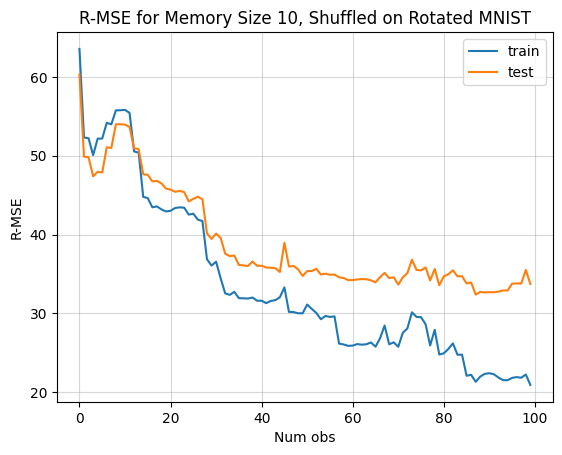

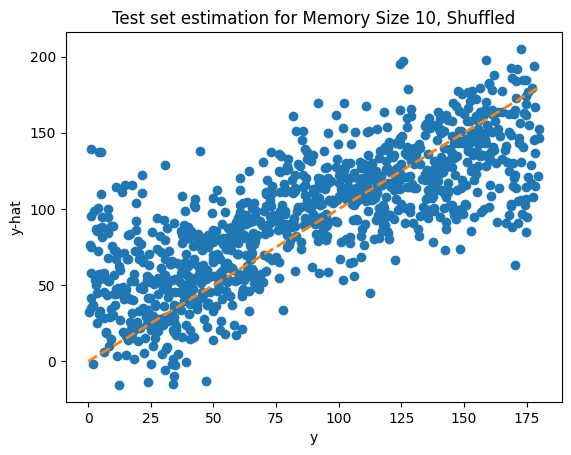

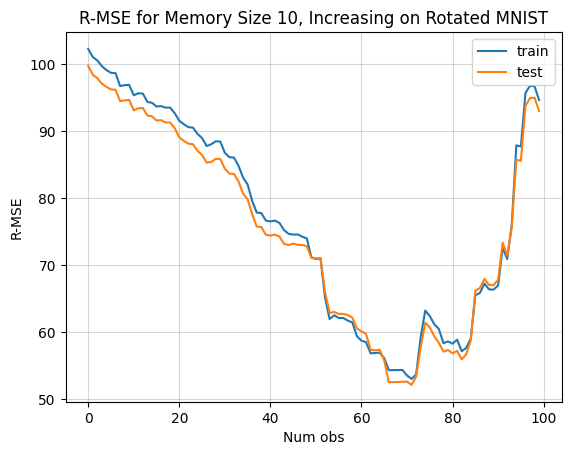

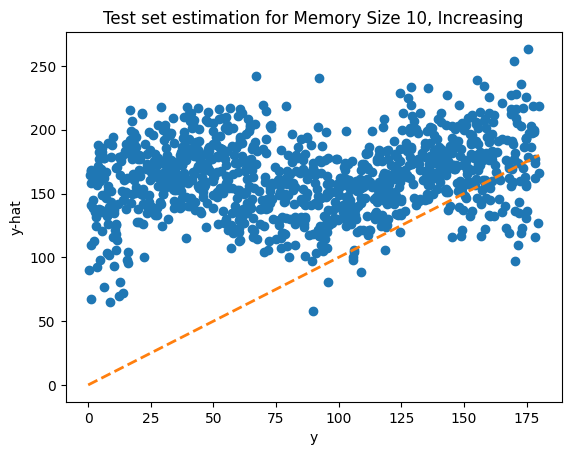

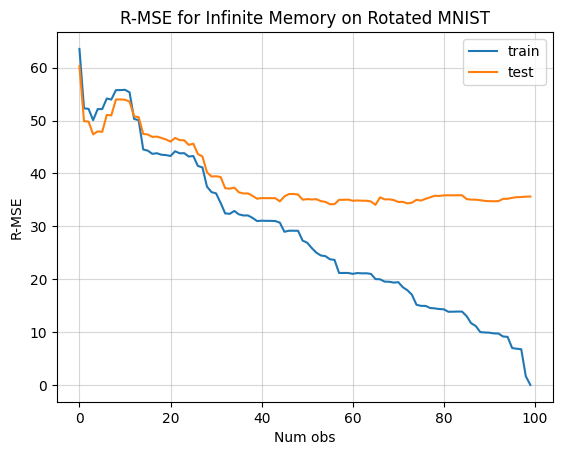

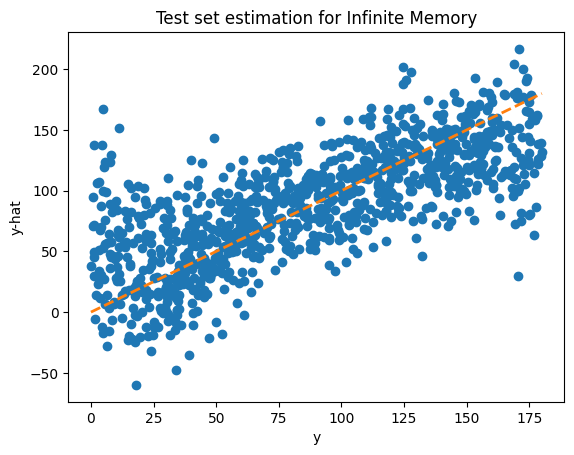

In [44]:
for name, history in filtered_means_rmnist.items():
    # Predict on train and test set
    yhat_hist_train = vmap(apply_fn_rmnist, (0, None))(history, X_train).squeeze()
    yhat_hist_test = vmap(apply_fn_rmnist, (0, None))(history, X_test).squeeze()

    rmae_hist_test = jnp.abs(yhat_hist_test - y_test[None, :]).mean(axis=-1)
    rmae_hist_train = jnp.abs(yhat_hist_train - y_train[None, :]).mean(axis=-1)

    rmse_hist_test = jnp.sqrt(((yhat_hist_test - y_test[None, :])**2).mean(axis=-1))
    rmse_hist_train = jnp.sqrt(((yhat_hist_train - y_train[None, :])**2).mean(axis=-1))

    fig, ax = plt.subplots()
    ax.plot(rmse_hist_train, label="train")
    ax.plot(rmse_hist_test, label="test")
    ax.legend()
    ax.set_xlabel("Num obs")
    ax.set_ylabel("R-MSE")
    ax.set_title(f"R-MSE for {name} on Rotated MNIST")
    plt.grid(alpha=0.5)

    yhat = apply_fn_rmnist(history[-1], X_test)
    fig, ax = plt.subplots()
    plt.scatter(y_test, yhat)
    plt.xlabel("y")
    plt.ylabel("y-hat")
    plt.plot([0,180], [0, 180], c="tab:orange", linestyle="--", linewidth=2)
    plt.title(f"Test set estimation for {name}");

## 4.2 Sample Prediction Error

Sample Prediction Error on the 16th example

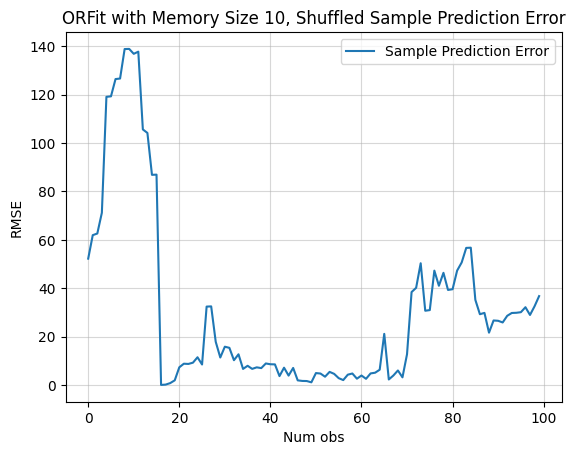

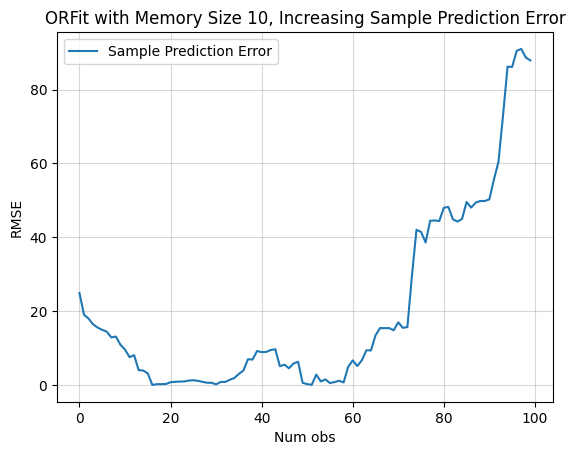

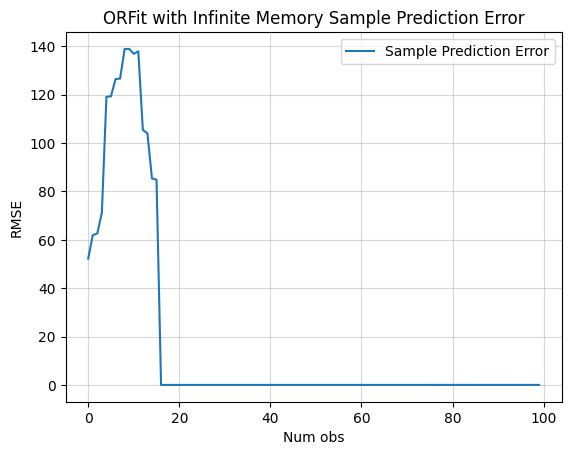

In [45]:
for name, history in filtered_means_rmnist.items():
    if name == "Memory Size 10, Increasing":
        yhats_sixteenth = vmap(apply_fn_rmnist, (0, None))(history, X_train_inc[16]).squeeze()
        err_hist_sixteenth = jnp.sqrt((yhats_sixteenth - y_train_inc[16])**2)
    else:
        yhats_sixteenth = vmap(apply_fn_rmnist, (0, None))(history, X_train[16]).squeeze()
        err_hist_sixteenth = jnp.sqrt((yhats_sixteenth - y_train[16])**2)

    fig, ax = plt.subplots()
    ax.plot(err_hist_sixteenth, label="Sample Prediction Error")
    ax.legend()
    ax.set_xlabel("Num obs")
    ax.set_ylabel("RMSE")
    ax.set_title(f"ORFit with {name} Sample Prediction Error")
    plt.grid(alpha=0.5)